In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [5]:
accuracy?

# Under the Hood: Training a Digit Classifier

Having seen what it looks like to actually train a variety of models in Chapter 2, let’s now look under the hood and see exactly what is going on. We’ll start by using computer vision to introduce fundamental tools and concepts for deep learning.

To be exact, we'll discuss the roles of arrays and tensors and of broadcasting, a powerful technique for using them expressively. We'll explain stochastic gradient descent (SGD), the mechanism for learning by updating weights automatically. We'll discuss the choice of a loss function for our basic classification task, and the role of mini-batches. We'll also describe the math that a basic neural network is actually doing. Finally, we'll put all these pieces together.

In future chapters we’ll do deep dives into other applications as well, and see how these concepts and tools generalize. But this chapter is about laying foundation stones. To be frank, that also makes this one of the hardest chapters, because of how these concepts all depend on each other. Like an arch, all the stones need to be in place for the structure to stay up. Also like an arch, once that happens, it's a powerful structure that can support other things. But it requires some patience to assemble.

Let's begin. The first step is to consider how images are represented in a computer.

## Pixels: The Foundations of Computer Vision

In order to understand what happens in a computer vision model, we first have to understand how computers handle images. We'll use one of the most famous datasets in computer vision, [MNIST](https://en.wikipedia.org/wiki/MNIST_database), for our experiments. MNIST contains images of handwritten digits, collected by the National Institute of Standards and Technology and collated into a machine learning dataset by Yann Lecun and his colleagues. Lecun used MNIST in 1998 in [Lenet-5](http://yann.lecun.com/exdb/lenet/), the first computer system to demonstrate practically useful recognition of handwritten digit sequences. This was one of the most important breakthroughs in the history of AI.

## Sidebar: Tenacity and Deep Learning

The story of deep learning is one of tenacity and grit by a handful of dedicated researchers. After early hopes (and hype!) neural networks went out of favor in the 1990's and 2000's, and just a handful of researchers kept trying to make them work well. Three of them, Yann Lecun, Yoshua Bengio, and Geoffrey Hinton, were awarded the highest honor in computer science, the Turing Award (generally considered the "Nobel Prize of computer science"), in 2018 after triumphing despite the deep skepticism and disinterest of the wider machine learning and statistics community.

Geoff Hinton has told of how even academic papers showing dramatically better results than anything previously published would be rejected by top journals and conferences, just because they used a neural network. Yann Lecun's work on convolutional neural networks, which we will study in the next section, showed that these models could read handwritten text—something that had never been achieved before. However, his breakthrough was ignored by most researchers, even as it was used commercially to read 10% of the checks in the US!

In addition to these three Turing Award winners, there are many other researchers who have battled to get us to where we are today. For instance, Jurgen Schmidhuber (who many believe should have shared in the Turing Award) pioneered many important ideas, including working with his student Sepp Hochreiter on the long short-term memory (LSTM) architecture (widely used for speech recognition and other text modeling tasks, and used in the IMDb example in <<chapter_intro>>). Perhaps most important of all, Paul Werbos in 1974 invented back-propagation for neural networks, the technique shown in this chapter and used universally for training neural networks ([Werbos 1994](https://books.google.com/books/about/The_Roots_of_Backpropagation.html?id=WdR3OOM2gBwC)). His development was almost entirely ignored for decades, but today it is considered the most important foundation of modern AI.

There is a lesson here for all of us! On your deep learning journey you will face many obstacles, both technical, and (even more difficult) posed by people around you who don't believe you'll be successful. There's one *guaranteed* way to fail, and that's to stop trying. We've seen that the only consistent trait amongst every fast.ai student that's gone on to be a world-class practitioner is that they are all very tenacious.

## End sidebar

For this initial tutorial we are just going to try to create a model that can classify any image as a 3 or a 7. So let's download a sample of MNIST that contains images of just these digits:

In [3]:
path = Path('/storage/data/mnist_sample/')
Path.BASE_PATH = path
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

We can see what's in this directory by using `ls`, a method added by fastai. This method returns an object of a special fastai class called `L`, which has all the same functionality of Python's built-in `list`, plus a lot more. One of its handy features is that, when printed, it displays the count of items, before listing the items themselves (if there are more than 10 items, it just shows the first few):

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Let's see what's inside the training set:

In [94]:
(path/'train').ls()

(#2) [Path('storage/data/mnist_sample/train/3'),Path('storage/data/mnist_sample/train/7')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the *labels* (or targets) in this dataset. Let's take a look in one of these folders (using `sorted` to ensure we all get the same order of files):

In [4]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

As we might expect, it's full of image files. Let’s take a look at one now. Here’s an image of a handwritten number 3, taken from the famous MNIST dataset of handwritten numbers:

In [5]:
im3_path = threes[1]
im3 = Image.open(im3_path)
type(im3),im3

(PIL.PngImagePlugin.PngImageFile,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7F5DDAFCB7D0>)

Here we are using the `Image` class from the *Python Imaging Library* (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.

In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a *NumPy array* or a *PyTorch tensor*. For instance, here's what a section of the image looks like, converted to a NumPy array:

In [ ]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

The `4:10` indicates we requested the rows from index 4 (included) to 10 (not included) and the same for the columns. NumPy indexes from top to bottom and left to right, so this section is located in the top-left corner of the image. Here's the same thing as a PyTorch tensor:

In [ ]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

In [ ]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


<img width="453" id="output_pd_pixels" src="images/att_00058.png">

You can see that the background white pixels are stored as the number 0, black is the number 255, and shades of gray are between the two. The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels. (This is much smaller than an image that you would get from a phone camera, which has millions of pixels, but is a convenient size for our initial learning and experiments. We will build up to bigger, full-color images soon.)

So, now you've seen what an image looks like to a computer, let's recall our goal: create a model that can recognize 3s and 7s. How might you go about getting a computer to do that?

> Warning: Stop and Think!: Before you read on, take a moment to think about how a computer might be able to recognize these two different digits. What kinds of features might it be able to look at? How might it be able to identify these features? How could it combine them together? Learning works best when you try to solve problems yourself, rather than just reading somebody else's answers; so step away from this book for a few minutes, grab a piece of paper and pen, and jot some ideas down…

## First Try: Pixel Similarity

So, here is a first idea: how about we find the average pixel value for every pixel of the 3s, then do the same for the 7s. This will give us two group averages, defining what we might call the "ideal" 3 and 7. Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. This certainly seems like it should be better than nothing, so it will make a good baseline.

> jargon: Baseline: A simple model which you are confident should perform reasonably well. It should be very simple to implement, and very easy to test, so that you can then test each of your improved ideas, and make sure they are always better than your baseline. Without starting with a sensible baseline, it is very difficult to know whether your super-fancy models are actually any good. One good approach to creating a baseline is doing what we have done here: think of a simple, easy-to-implement model. Another good approach is to search around to find other people that have solved similar problems to yours, and download and run their code on your dataset. Ideally, try both of these!

Step one for our simple model is to get the average of pixel values for each of our two groups. In the process of doing this, we will learn a lot of neat Python numeric programming tricks!

Let's create a tensor containing all of our 3s stacked together. We already know how to create a tensor containing a single image. To create a tensor containing all the images in a directory, we will first use a Python list comprehension to create a plain list of the single image tensors.

We will use Jupyter to do some little checks of our work along the way—in this case, making sure that the number of returned items seems reasonable:

In [20]:
doc(tensor)

In [7]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

> note: List Comprehensions: List and dictionary comprehensions are a wonderful feature of Python. Many Python programmers use them every day, including the authors of this book—they are part of "idiomatic Python." But programmers coming from other languages may have never seen them before. There are a lot of great tutorials just a web search away, so we won't spend a long time discussing them now. Here is a quick explanation and example to get you started. A list comprehension looks like this: `new_list = [f(o) for o in a_list if o>0]`. This will return every element of `a_list` that is greater than 0, after passing it to the function `f`. There are three parts here: the collection you are iterating over (`a_list`), an optional filter (`if o>0`), and something to do to each element (`f(o)`). It's not only shorter to write but way faster than the alternative ways of creating the same list with a loop.

We'll also check that one of the images looks okay. Since we now have tensors (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's `show_image` function to display it:

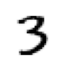

In [56]:
show_image(three_tensors[1]);

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a *rank-3 tensor*. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called `stack` that we can use for this purpose.

Some operations in PyTorch, such as taking a mean, require us to *cast* our integer types to float types. Since we'll be needing this later, we'll also cast our stacked tensor to `float` now. Casting in PyTorch is as simple as typing the name of the type you wish to cast to, and treating it as a method.

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:

In [8]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

Perhaps the most important attribute of a tensor is its *shape*. This tells you the length of each axis. In this case, we can see that we have 6,131 images, each of size 28×28 pixels. There is nothing specifically about this tensor that says that the first axis is the number of images, the second is the height, and the third is the width—the semantics of a tensor are entirely up to us, and how we construct it. As far as PyTorch is concerned, it is just a bunch of numbers in memory.

The *length* of a tensor's shape is its rank:

In [ ]:
len(stacked_threes.shape)

3

It is really important for you to commit to memory and practice these bits of tensor jargon: _rank_ is the number of axes or dimensions in a tensor; _shape_ is the size of each axis of a tensor.

> A: Watch out because the term "dimension" is sometimes used in two ways. Consider that we live in "three-dimensonal space" where a physical position can be described by a 3-vector `v`. But according to PyTorch, the attribute `v.ndim` (which sure looks like the "number of dimensions" of `v`) equals one, not three! Why? Because `v` is a vector, which is a tensor of rank one, meaning that it has only one _axis_ (even if that axis has a length of three). In other words, sometimes dimension is used for the size of an axis ("space is three-dimensional"); other times, it is used for the rank, or the number of axes ("a matrix has two dimensions"). When confused, I find it helpful to translate all statements into terms of rank, axis, and length, which are unambiguous terms.

We can also get a tensor's rank directly with `ndim`:

In [ ]:
stacked_threes.ndim

3

Finally, we can compute what the ideal 3 looks like. We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.

In other words, for every pixel position, this will compute the average of that pixel over all images. The result will be one value for every pixel position, or a single image. Here it is:

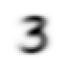

In [9]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

According to this dataset, this is the ideal number 3! (You may not like it, but this is what peak number 3 performance looks like.) You can see how it's very dark where all the images agree it should be dark, but it becomes wispy and blurry where the images disagree. 

Let's do the same thing for the 7s, but put all the steps together at once to save some time:

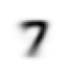

In [10]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Let's now pick an arbitrary 3 and measure its *distance* from our "ideal digits."

> stop: Stop and Think!: How would you calculate how similar a particular image is to each of our ideal digits? Remember to step away from this book and jot down some ideas before you move on! Research shows that recall and understanding improves dramatically when you are engaged with the learning process by solving problems, experimenting, and trying new ideas yourself

Here's a sample 3:

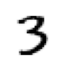

In [11]:
a_3 = stacked_threes[1]
show_image(a_3);

How can we determine its distance from our ideal 3? We can't just add up the differences between the pixels of this image and the ideal digit. Some differences will be positive while others will be negative, and these differences will cancel out, resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal. That would be misleading!

To avoid this, there are two main ways data scientists measure distance in this context:

- Take the mean of the *absolute value* of differences (absolute value is the function that replaces negative values with positive values). This is called the *mean absolute difference* or *L1 norm*
- Take the mean of the *square* of differences (which makes everything positive) and then take the *square root* (which undoes the squaring). This is called the *root mean squared error* (RMSE) or *L2 norm*.

> important: It's Okay to Have Forgotten Your Math: In this book we generally assume that you have completed high school math, and remember at least some of it... But everybody forgets some things! It all depends on what you happen to have had reason to practice in the meantime. Perhaps you have forgotten what a _square root_ is, or exactly how they work. No problem! Any time you come across a maths concept that is not explained fully in this book, don't just keep moving on; instead, stop and look it up. Make sure you understand the basic idea, how it works, and why we might be using it. One of the best places to refresh your understanding is Khan Academy. For instance, Khan Academy has a great [introduction to square roots](https://www.khanacademy.org/math/algebra/x2f8bb11595b61c86:rational-exponents-radicals/x2f8bb11595b61c86:radicals/v/understanding-square-roots).

Let's try both of these now:

In [12]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [13]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. So our simple model will give the right prediction in this case.

PyTorch already provides both of these as *loss functions*. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as `F` (and is available by default under that name in fastai):

In [14]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [11]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

## The MNIST Loss Function

We already have our independent variables `x`—these are the images themselves. We'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). We can do this using `view`, which is a PyTorch method that changes the shape of a tensor without changing its contents. `-1` is a special parameter to `view` that means "make this axis as big as necessary to fit all the data":

In [12]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

We need a label for each image. We'll use `1` for 3s and `0` for 7s:

In [13]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [14]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [41]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))
valid_y.float().mean()

tensor(0.4956)

Now we need an (initially random) weight for every pixel (this is the *initialize* step in our seven-step process):

In [28]:
def init_params(size, seed=None, std=1.0):
    if seed is not None:
        torch.manual_seed(seed)
    else:
        torch.seed()
    return (torch.randn(size)*std).requires_grad_()

In [42]:
def linear1(xb): return torch.sigmoid(xb@weights + bias)
preds = linear1(train_x)
preds

tensor([[1.9392e-03],
        [2.3717e-05],
        [8.4054e-10],
        ...,
        [1.2092e-07],
        [1.5484e-01],
        [1.1567e-05]], grad_fn=<SigmoidBackward0>)

In [58]:
def linear2(weights, bias, xb):
    return torch.sigmoid(xb@weights + bias)

Here's a first try at a loss function that measures the distance between `predictions` and `targets`:

In [18]:
def sigmoid(x): return 1/(1+torch.exp(-x))

Pytorch defines an accelerated version for us, so we don’t really need our own. This is an important function in deep learning, since we often want to ensure values are between 0 and 1. This is what it looks like:

/opt/conda/lib/python3.7/site-packages/fastbook/__init__.py:74: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


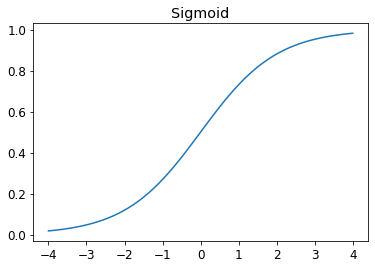

In [41]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

As you can see, it takes any input value, positive or negative, and smooshes it onto an output value between 0 and 1. It's also a smooth curve that only goes up, which makes it easier for SGD to find meaningful gradients. 

Let's update `mnist_loss` to first apply `sigmoid` to the inputs:

In [19]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

mnist_loss(tensor(0.7), tensor(1.))

tensor(0.3318)

## Putting It All Together

It's time to implement the process we saw in <<gradient_descent>>. In code, our process will be implemented something like this for each epoch:

```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

First, let's re-initialize our parameters:

In [22]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

and test it:

In [57]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape, xb.mean(), yb.float().mean()

(torch.Size([256, 784]), torch.Size([256, 1]), tensor(0.1472), tensor(1.))

In [56]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

That gives us this function to calculate our validation accuracy:

In [20]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

We can check it works:

In [45]:
batch_accuracy(linear1(batch), train_y[:4])

NameError: name 'batch' is not defined

and then put the batches together:

In [26]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [67]:
def accuracy(preds, labels):
    correct = (preds>0.5) == labels
    return correct.float().mean()

def model_accuracy(model, xs, ys):
    preds = model(xs)
    return accuracy(preds, ys)

model_accuracy(partial(linear2, tensor([ [1.], [ 2.] ]), tensor(1.)), 
               tensor([ [3., 4.], [5., 9.] ]), tensor([1., 4.]))

# tensor([ [3. , 4.], [ 23., 674.] ]).shape

tensor(0.5000)

In [68]:
weights = init_params((28*28,1), seed=42)
bias = init_params(1, seed=42)
preds = linear1(valid_x)

model_accuracy(partial(linear2, weights, bias), valid_x, valid_y)

tensor(0.5456)

In [47]:
validate_epoch(linear1)

0.6583

That's our starting point. Let's train for one epoch, and see if the accuracy improves:

In [53]:
valid_dl = DataLoader(valid_dset, batch_size=256)

#### Training ONE Epoch

In [71]:
weights = init_params((28 * 28, 1), seed=42)
bias = init_params(1, seed=42)

lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1), model_accuracy(linear1, valid_x, valid_y)

(0.5254, tensor(0.6658))

In [70]:
def create_dl(xs, ys):
    torch.manual_seed(42)
    return DataLoader(list(zip(xs, ys)), batch_size=256)

dl = create_dl(train_x, train_y)
f = first(dl)
f[0].mean(), f[1].float().mean()

(tensor(0.1472), tensor(1.))

####  Training Multiple Epochs

In [74]:
weights = init_params((28 * 28, 1), seed=42)
bias = init_params(1, seed=42)

lr = 1.
params = weights,bias

initial_weights = weights.clone().detach()
initial_bias = bias.clone().detach()

for i in range(21):
    train_epoch(linear1, lr, params)
    print(f'validate_epoch = {validate_epoch(linear1)}, model_accuracy ={model_accuracy(linear1, valid_x, valid_y)}')
    
final_weights = weights.clone().detach()
final_bias = weights.clone().detach()

validate_epoch = 0.5254, model_accuracy =0.6658488512039185
validate_epoch = 0.5485, model_accuracy =0.7806673049926758
validate_epoch = 0.5548, model_accuracy =0.8434739708900452
validate_epoch = 0.5672, model_accuracy =0.8709518909454346
validate_epoch = 0.5776, model_accuracy =0.8905789852142334
validate_epoch = 0.5869, model_accuracy =0.9072620272636414
validate_epoch = 0.6031, model_accuracy =0.9195289611816406
validate_epoch = 0.6169, model_accuracy =0.9278704524040222
validate_epoch = 0.6293, model_accuracy =0.9317958950996399
validate_epoch = 0.6451, model_accuracy =0.9367026686668396
validate_epoch = 0.6555, model_accuracy =0.9411187171936035
validate_epoch = 0.6634, model_accuracy =0.9430814385414124
validate_epoch = 0.6737, model_accuracy =0.9460254907608032
validate_epoch = 0.6786, model_accuracy =0.947497546672821
validate_epoch = 0.686, model_accuracy =0.9479882121086121
validate_epoch = 0.6929, model_accuracy =0.9484788775444031
validate_epoch = 0.7023, model_accuracy =0

Then do a few more:

Looking good! We're already about at the same accuracy as our "pixel similarity" approach, and we've created a general-purpose foundation we can build on. Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it's called an *optimizer*.

### Creating an Optimizer

Because this is such a general foundation, PyTorch provides some useful classes to make it easier to implement. The first thing we can do is replace our `linear1` function with PyTorch's `nn.Linear` module. A *module* is an object of a class that inherits from the PyTorch `nn.Module` class. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

`nn.Linear` does the same thing as our `init_params` and `linear` together. It contains both the *weights* and *biases* in a single class. Here's how we replicate our model from the previous section:

In [ ]:
linear_model = nn.Linear(28*28,1)

Every PyTorch module knows what parameters it has that can be trained; they are available through the `parameters` method:

In [ ]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to create an optimizer:

In [ ]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

We can create our optimizer by passing in the model's parameters:

In [ ]:
opt = BasicOptim(linear_model.parameters(), lr)

Our training loop can now be simplified to:

In [ ]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

Our validation function doesn't need to change at all:

In [ ]:
validate_epoch(linear_model)

0.4157

Let's put our little training loop in a function, to make things simpler:

In [ ]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

The results are the same as in the previous section:

In [ ]:
train_model(linear_model, 20)

0.4932 0.8618 0.8203 0.9102 0.9331 0.9468 0.9555 0.9629 0.9658 0.9673 0.9687 0.9707 0.9726 0.9751 0.9761 0.9761 0.9775 0.978 0.9785 0.9785 

fastai provides the `SGD` class which, by default, does the same thing as our `BasicOptim`:

In [ ]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.852 0.8335 0.9116 0.9326 0.9473 0.9555 0.9624 0.9648 0.9668 0.9692 0.9712 0.9731 0.9746 0.9761 0.9765 0.9775 0.978 0.9785 0.9785 

fastai also provides `Learner.fit`, which we can use instead of `train_model`. To create a `Learner` we first need to create a `DataLoaders`, by passing in our training and validation `DataLoader`s:

In [55]:
dls = DataLoaders(dl, valid_dl)

To create a `Learner` without using an application (such as `cnn_learner`) we need to pass in all the elements that we've created in this chapter: the `DataLoaders`, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

In [56]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

Now we can call `fit`:

In [57]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636127,0.503284,0.495584,00:00
1,0.452452,0.239455,0.785574,00:00
2,0.169332,0.163602,0.852306,00:00
3,0.075958,0.101016,0.915113,00:00
4,0.041381,0.074995,0.933759,00:00
5,0.027756,0.060634,0.947988,00:00
6,0.022081,0.051589,0.957311,00:00
7,0.019510,0.045535,0.963690,00:00
8,0.018172,0.041269,0.965653,00:00
9,0.017349,0.038120,0.968597,00:00


As you can see, there's nothing magic about the PyTorch and fastai classes. They are just convenient pre-packaged pieces that make your life a bit easier! (They also provide a lot of extra functionality we'll be using in future chapters.)

With these classes, we can now replace our linear model with a neural network.

## Adding a Nonlinearity

So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

Here is the entire definition of a basic neural network:

In [ ]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

That's it! All we have in `simple_net` is two linear classifiers with a `max` function between them.

Here, `w1` and `w2` are weight tensors, and `b1` and `b2` are bias tensors; that is, parameters that are initially randomly initialized, just like we did in the previous section:

In [ ]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

The key point about this is that `w1` has 30 output activations (which means that `w2` must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels. You can change that `30` to anything you like, to make the model more or less complex.

That little function `res.max(tensor(0.0))` is called a *rectified linear unit*, also known as *ReLU*. We think we can all agree that *rectified linear unit* sounds pretty fancy and complicated... But actually, there's nothing more to it than `res.max(tensor(0.0))`—in other words, replace every negative number with a zero. This tiny function is also available in PyTorch as `F.relu`:

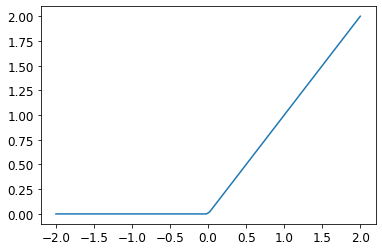

In [ ]:
plot_function(F.relu)

> J: There is an enormous amount of jargon in deep learning, including terms like _rectified linear unit_. The vast vast majority of this jargon is no more complicated than can be implemented in a short line of code, as we saw in this example. The reality is that for academics to get their papers published they need to make them sound as impressive and sophisticated as possible. One of the ways that they do that is to introduce jargon. Unfortunately, this has the result that the field ends up becoming far more intimidating and difficult to get into than it should be. You do have to learn the jargon, because otherwise papers and tutorials are not going to mean much to you. But that doesn't mean you have to find the jargon intimidating. Just remember, when you come across a word or phrase that you haven't seen before, it will almost certainly turn out to be referring to a very simple concept.

The basic idea is that by using more linear layers, we can have our model do more computation, and therefore model more complex functions. But there's no point just putting one linear layer directly after another one, because when we multiply things together and then add them up multiple times, that could be replaced by multiplying different things together and adding them up just once! That is to say, a series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.

But if we put a nonlinear function between them, such as `max`, then this is no longer true. Now each linear layer is actually somewhat decoupled from the other ones, and can do its own useful work. The `max` function is particularly interesting, because it operates as a simple `if` statement.

> S: Mathematically, we say the composition of two linear functions is another linear function. So, we can stack as many linear classifiers as we want on top of each other, and without nonlinear functions between them, it will just be the same as one linear classifier.

Amazingly enough, it can be mathematically proven that this little function can solve any computable problem to an arbitrarily high level of accuracy, if you can find the right parameters for `w1` and `w2` and if you make these matrices big enough. For any arbitrarily wiggly function, we can approximate it as a bunch of lines joined together; to make it closer to the wiggly function, we just have to use shorter lines. This is known as the *universal approximation theorem*. The three lines of code that we have here are known as *layers*. The first and third are known as *linear layers*, and the second line of code is known variously as a *nonlinearity*, or *activation function*.

Just like in the previous section, we can replace this code with something a bit simpler, by taking advantage of PyTorch:

In [53]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

`nn.Sequential` creates a module that will call each of the listed layers or functions in turn.

`nn.ReLU` is a PyTorch module that does exactly the same thing as the `F.relu` function. Most functions that can appear in a model also have identical forms that are modules. Generally, it's just a case of replacing `F` with `nn` and changing the capitalization. When using `nn.Sequential`, PyTorch requires us to use the module version. Since modules are classes, we have to instantiate them, which is why you see `nn.ReLU()` in this example. 

Because `nn.Sequential` is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. Let's try it out! As this is a deeper model, we'll use a lower learning rate and a few more epochs.

In [54]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

NameError: name 'dls' is not defined

In [ ]:
#hide_output
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.305828,0.399663,0.508341,00:00
1,0.142960,0.225702,0.807655,00:00
2,0.079516,0.113519,0.919529,00:00
3,0.052391,0.076792,0.943081,00:00
4,0.039796,0.060083,0.956330,00:00
5,0.033368,0.050713,0.963690,00:00
6,0.029680,0.044797,0.965653,00:00
7,0.027290,0.040729,0.968106,00:00
8,0.025568,0.037771,0.968597,00:00
9,0.024233,0.035508,0.970559,00:00


We're not showing the 40 lines of output here to save room; the training process is recorded in `learn.recorder`, with the table of output stored in the `values` attribute, so we can plot the accuracy over training as:

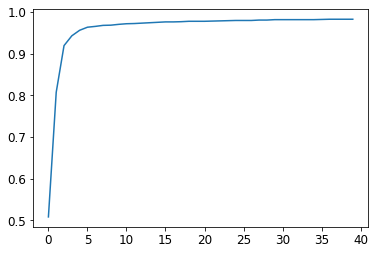

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

And we can view the final accuracy:

In [ ]:
learn.recorder.values[-1][2]

0.982826292514801

At this point we have something that is rather magical:

1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
1. A way to find the best set of parameters for any function (stochastic gradient descent)

This is why deep learning can do things which seem rather magical, such fantastic things. Believing that this combination of simple techniques can really solve any problem is one of the biggest steps that we find many students have to take. It seems too good to be true—surely things should be more difficult and complicated than this? Our recommendation: try it out! We just tried it on the MNIST dataset and you have seen the results. And since we are doing everything from scratch ourselves (except for calculating the gradients) you know that there is no special magic hiding behind the scenes.

### Going Deeper

There is no need to stop at just two linear layers. We can add as many as we want, as long as we add a nonlinearity between each pair of linear layers. As you will learn, however, the deeper the model gets, the harder it is to optimize the parameters in practice. Later in this book you will learn about some simple but brilliantly effective techniques for training deeper models.

We already know that a single nonlinearity with two linear layers is enough to approximate any function. So why would we use deeper models? The reason is performance. With a deeper model (that is, one with more layers) we do not need to use as many parameters; it turns out that we can use smaller matrices with more layers, and get better results than we would get with larger matrices, and few layers.

That means that we can train the model more quickly, and it will take up less memory. In the 1990s researchers were so focused on the universal approximation theorem that very few were experimenting with more than one nonlinearity. This theoretical but not practical foundation held back the field for years. Some researchers, however, did experiment with deep models, and eventually were able to show that these models could perform much better in practice. Eventually, theoretical results were developed which showed why this happens. Today, it is extremely unusual to find anybody using a neural network with just one nonlinearity.

Here what happens when we train an 18-layer model using the same approach we saw in <<chapter_intro>>:

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.082089,0.009578,0.997056,00:11


Nearly 100% accuracy! That's a big difference compared to our simple neural net. But as you'll learn in the remainder of this book, there are just a few little tricks you need to use to get such great results from scratch yourself. You already know the key foundational pieces. (Of course, even once you know all the tricks, you'll nearly always want to work with the pre-built classes provided by PyTorch and fastai, because they save you having to think about all the little details yourself.)

## Jargon Recap

Congratulations: you now know how to create and train a deep neural network from scratch! We've gone through quite a few steps to get to this point, but you might be surprised at how simple it really is.

Now that we are at this point, it is a good opportunity to define, and review, some jargon and key concepts.

A neural network contains a lot of numbers, but they are only of two types: numbers that are calculated, and the parameters that these numbers are calculated from. This gives us the two most important pieces of jargon to learn:

- Activations:: Numbers that are calculated (both by linear and nonlinear layers)
- Parameters:: Numbers that are randomly initialized, and optimized (that is, the numbers that define the model)

We will often talk in this book about activations and parameters. Remember that they have very specific meanings. They are numbers. They are not abstract concepts, but they are actual specific numbers that are in your model. Part of becoming a good deep learning practitioner is getting used to the idea of actually looking at your activations and parameters, and plotting them and testing whether they are behaving correctly.

Our activations and parameters are all contained in *tensors*. These are simply regularly shaped arrays—for example, a matrix. Matrices have rows and columns; we call these the *axes* or *dimensions*. The number of dimensions of a tensor is its *rank*. There are some special tensors:

- Rank zero: scalar
- Rank one: vector
- Rank two: matrix

A neural network contains a number of layers. Each layer is either *linear* or *nonlinear*. We generally alternate between these two kinds of layers in a neural network. Sometimes people refer to both a linear layer and its subsequent nonlinearity together as a single layer. Yes, this is confusing. Sometimes a nonlinearity is referred to as an *activation function*.

<<dljargon1>> summarizes the key concepts related to SGD.

```asciidoc
[[dljargon1]]
.Deep learning vocabulary
[options="header"]
|=====
| Term | Meaning
|ReLU | Function that returns 0 for negative numbers and doesn't change positive numbers.
|Mini-batch | A small group of inputs and labels gathered together in two arrays. A gradient descent step is updated on this batch (rather than a whole epoch).
|Forward pass | Applying the model to some input and computing the predictions.
|Loss | A value that represents how well (or badly) our model is doing.
|Gradient | The derivative of the loss with respect to some parameter of the model.
|Backward pass | Computing the gradients of the loss with respect to all model parameters.
|Gradient descent | Taking a step in the directions opposite to the gradients to make the model parameters a little bit better.
|Learning rate | The size of the step we take when applying SGD to update the parameters of the model.
|=====
```

> note: _Choose Your Own Adventure_ Reminder: Did you choose to skip over chapters 2 & 3, in your excitement to peek under the hood? Well, here's your reminder to head back to chapter 2 now, because you'll be needing to know that stuff very soon!

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
A. 

1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

In [2]:
accuracy?

Object `accuracy` not found.


### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.